# MultiLayer Multiclass Classification

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST,EMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


/home/bikasherl/miniconda3/envs/bajra/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
def softmax(Z):
    return (torch.exp(Z)/torch.sum(torch.exp(Z),dim=1,keepdim=True))

In [3]:
def categorical_cross_entropy(Y_enc_train,Y_hat):
    return torch.sum((-Y_enc_train*torch.log(Y_hat)),dim=1,keepdim=True).mean()
 

## Deriving the Jacobian Matrix

In [8]:
# def calc_jacob(X,y,a):
#     jacob = torch.zeros((X.shape[0],y.shape[1],y.shape[1]),dtype=torch.float32)
#     for j in range(X.shape[0]):
#         for i in range(y.shape[1]):
#             temp=a[j][i].item()
#             jacob[j][i] = torch.where(a[j]==temp,temp*(1-temp),-temp*a[j])
#     return jacob

# def get_dL_dZ(jacob,dL_da):
#     return jacob@dL_da

# EMNIST Dataset

In [9]:
# # Calculating Gradients

# # dL_dZ= (Y_hat_grad-Y_enc_train)/X_train.shape[0]
# jacob=calc_jacob(X_train,Y_enc_train,Y_hat_grad)

# dL_dZ=get_dL_dZ(jacob,dL_da)
# dZ_dW= X_train

# dL_dW=dZ_dW.T@dL_dZ.squeeze(2)

# dL_db=torch.sum(dL_dZ.squeeze(2),dim=0,keepdim=True)

# print(f"shape- dL_dZ: {dL_dZ.shape}\
#        \nshape- dZ_dW: {dZ_dW.shape}\
#       \nshape- dL_dW: {dL_dW.shape}\
#       \nshape- dL_db: {dL_db.shape}")

In [4]:
train_edata=EMNIST(root='emnist_dataset/train/',split='balanced',train=True,download=True,transform=ToTensor())
test_edata=EMNIST(root='emnist_dataset/test/',split='balanced',train=False,download=True,transform=ToTensor())
train_edata,test_edata

(Dataset EMNIST
     Number of datapoints: 112800
     Root location: emnist_dataset/train/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset EMNIST
     Number of datapoints: 18800
     Root location: emnist_dataset/test/
     Split: Test
     StandardTransform
 Transform: ToTensor())

## Lets See How the Dataset Looks Like

80


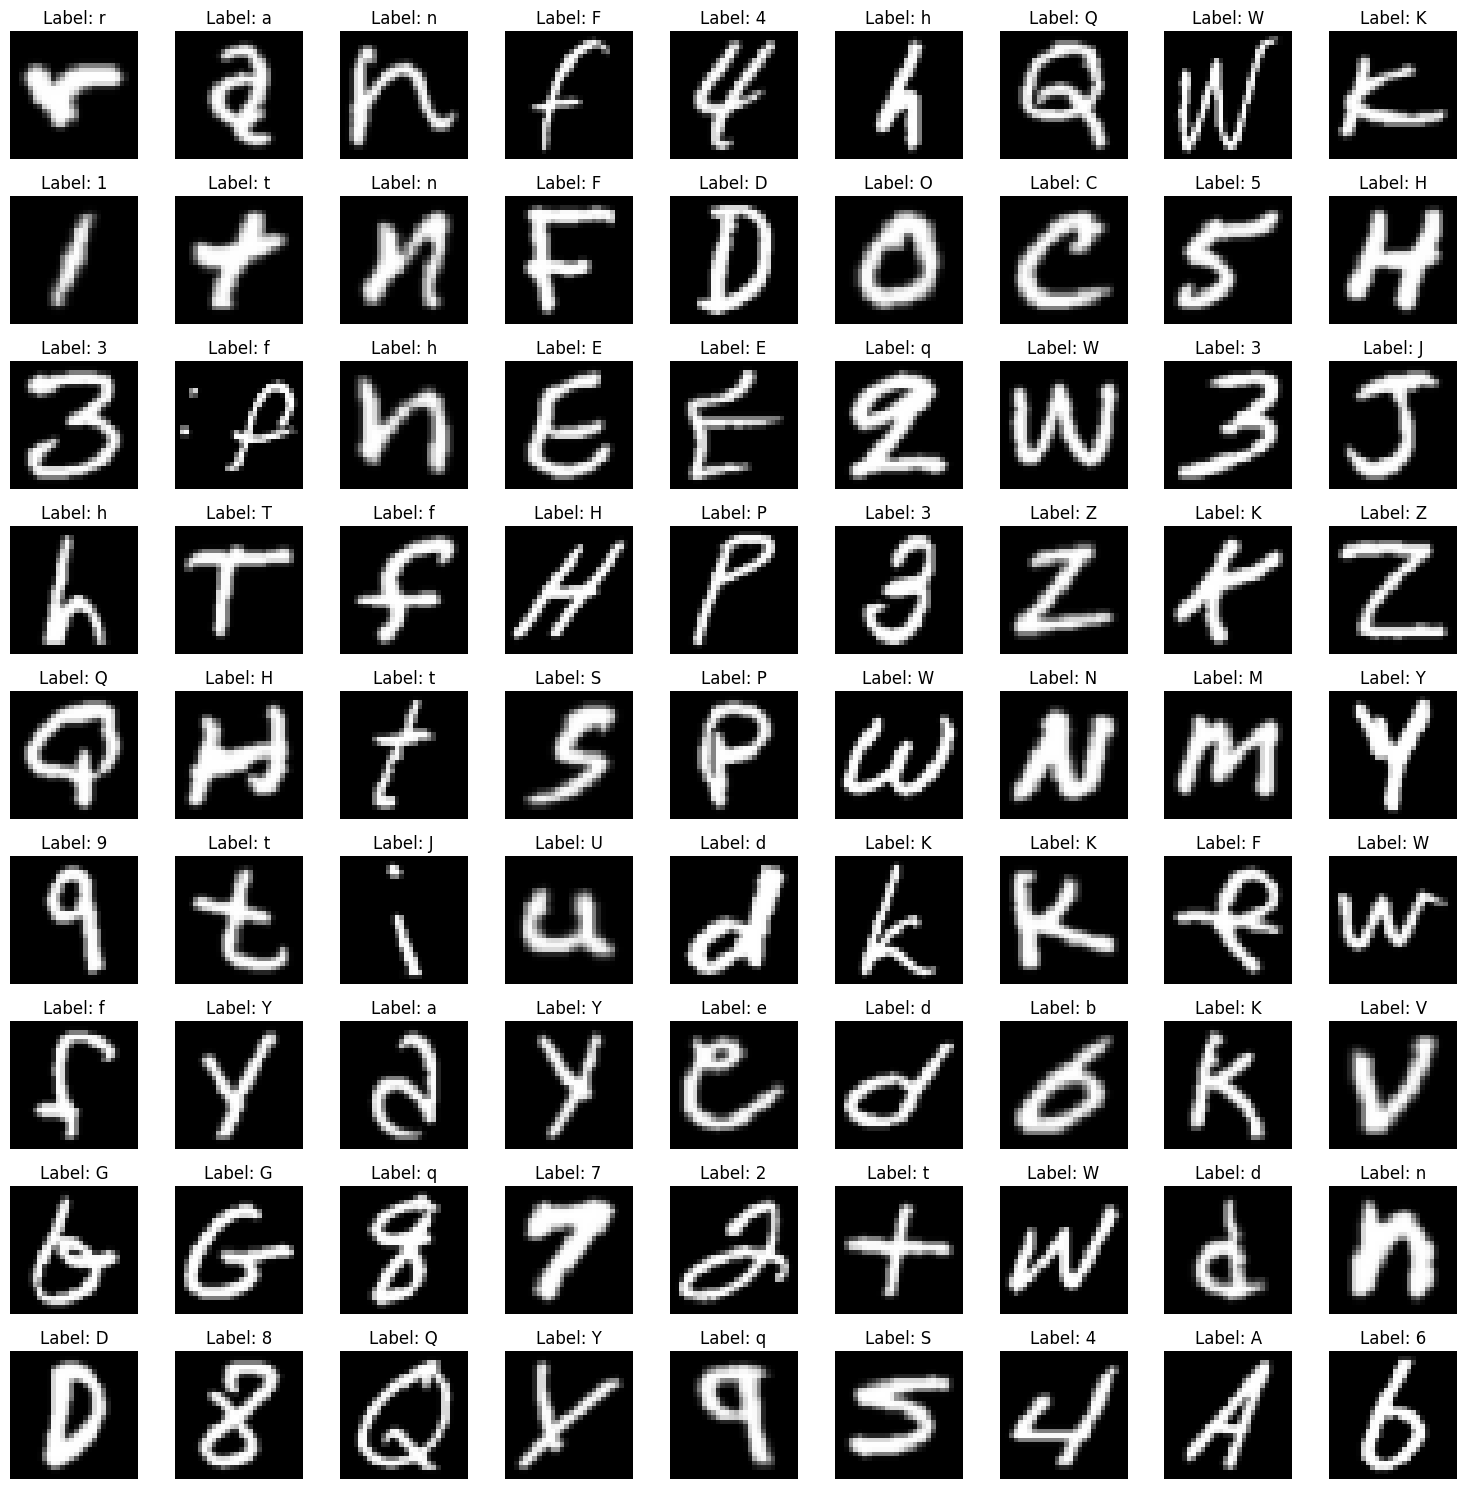

In [11]:
# Create subplots
fig, axs = plt.subplots(9, 9, figsize=(15, 15))

# Plot images
# Plot images
c=-1
j=0
i=-1

end_loop=False

while i!=9:
    if end_loop:
        print(c)
        break
    i+=1
    j=0
    while j!=9:
        c+=1
        img, label = train_edata[c]  # Accessing each image and label
        if list((train_edata.class_to_idx).keys())[label]:  #=='q':   can filter specific character
            axs[i, j].imshow(img.squeeze().T,cmap='gray')
            axs[i, j].set_title(f'Label: {list((train_edata.class_to_idx).keys())[label]}')
            axs[i, j].axis('off')  # Hide axis
            j+=1
        if((c==2000) or (i==8 and j>8)):  # could scan maximum of 2k images and minimum of 81 elements
            end_loop=True
            break        


plt.tight_layout()
plt.show()


## Train and Test Set Preparation

In [5]:
#train set
X_etrain=torch.flatten(train_edata.data,1,2).to(torch.float32)
Y_etrain=train_edata.targets.reshape(X_etrain.shape[0],1).to(torch.int8)

X_etrain.shape,Y_etrain.shape

# test set
X_etest=torch.flatten(test_edata.data,1,2).to(torch.float32)
Y_etest=test_edata.targets.reshape(X_etest.shape[0],1).to(torch.int8)

X_etrain.shape,Y_etrain.shape,X_etest.shape,Y_etest.shape

(torch.Size([112800, 784]),
 torch.Size([112800, 1]),
 torch.Size([18800, 784]),
 torch.Size([18800, 1]))

## Min max Scaling of Train and Test Data

In [6]:
# scaling train dataset
for i in range(X_etrain.shape[0]):
    X_etrain[i]=(X_etrain[i]-X_etrain[i].min())/(X_etrain[i].max()-X_etrain[i].min())


# scaling test dataset
for i in range(X_etest.shape[0]):
    X_etest[i]=(X_etest[i]-X_etest[i].min())/(X_etest[i].max()-X_etest[i].min())

In [14]:
Y_etrain[1]

tensor([36], dtype=torch.int8)

## One hot encoding for the labels

In [7]:
## One hot encoding For the labels

Y_enc_etrain=torch.zeros((Y_etrain.shape[0],len(train_edata.classes))).to(torch.int8)

for i in range(Y_etrain.shape[0]):
    Y_enc_etrain[i][Y_etrain[i].item()]=1


Y_enc_etest=torch.zeros((Y_etest.shape[0],len(test_edata.classes))).to(torch.int8)

for i in range(Y_etest.shape[0]):
    Y_enc_etest[i][Y_etest[i].item()]=1


Y_enc_etrain.shape,Y_enc_etest.shape

(torch.Size([112800, 47]), torch.Size([18800, 47]))

## Weights and Bias Initialization

In [8]:
# Weight and Bias Initialization

# # this one is for testing manually computed gradient
# w_etest=torch.randn((X_etrain.shape[1],Y_enc_etrain.shape[1]),dtype=torch.float64,requires_grad=True)
# b_etest=torch.randn((1,Y_enc_etrain.shape[1]),dtype=torch.float64,requires_grad=True)


# kaiming weight initialization
# W=torch.randn((X_etrain.shape[1],Y_enc_etrain.shape[1]),dtype=torch.float32,requires_grad=False)*torch.sqrt(torch.tensor(2/X_etrain.shape[1]))
# b=torch.randn((1,Y_enc_etrain.shape[1]),dtype=torch.float32,requires_grad=False)*0.01


num_input=X_etrain.shape[1]
num_hidden=128


# kaiming weight initialization
W1=torch.randn((num_input,num_hidden),dtype=torch.float32,requires_grad=True)*torch.sqrt(torch.tensor(2/num_input))
b1=torch.randn((1,num_hidden),dtype=torch.float32,requires_grad=True)*torch.sqrt(torch.tensor(2/num_input))

W2=torch.randn((num_hidden,Y_enc_etrain.shape[1]),dtype=torch.float32,requires_grad=True)*torch.sqrt(torch.tensor(2/num_hidden))
b2=torch.randn((1,Y_enc_etrain.shape[1]),dtype=torch.float32,requires_grad=True)*torch.sqrt(torch.tensor(2/num_hidden))


print(f"shape- W1: {W1.shape}\
       \nshape- b1: {b1.shape}\
      \nshape- W2: {W2.shape}\
      \nshape- b2: {b2.shape}")



# # Xavier Weight Initialization

# interval=torch.sqrt(torch.tensor(6)/(X_etrain.shape[1]+Y_enc_etrain.shape[1]))

# W=torch.zeros((X_etrain.shape[1],Y_enc_etrain.shape[1]),dtype=torch.float32).uniform_(-interval,interval)
# b=torch.zeros((1,Y_enc_etrain.shape[1]),dtype=torch.float32).uniform_(-interval,interval)

# W.shape,b.shape

shape- W1: torch.Size([784, 128])       
shape- b1: torch.Size([1, 128])      
shape- W2: torch.Size([128, 47])      
shape- b2: torch.Size([1, 47])


In [9]:
loss_list_train=[]
loss_list_test=[]

## Building and Training the Model

In [18]:

for epoch in range(1000):

    # forward pass
    Z1=X_etrain@W1 + b1
    A1=torch.relu(Z1)

    Z2=A1@W2 + b2
    Y_ehat=softmax(Z2)
    
    Loss=categorical_cross_entropy(Y_enc_etrain,Y_ehat)
    # Loss=torch.sum((-Y_enc_etrain*torch.log(Y_ehat)),dim=1,keepdim=True).mean()

    loss_list_train.append(Loss.item())

    # backpropgation
    dL_dZ2=(Y_ehat-Y_enc_etrain)/X_etrain.shape[0]
    dZ2_dW2=A1
    
    dL_dW2=dZ2_dW2.T@dL_dZ2
    dL_db2=torch.sum(dL_dZ2,dim=0,keepdim=True)


    dZ2_dA1=W2
    dL_dA1= dL_dZ2 @ dZ2_dA1.T


    dA1_dZ1=torch.where((Z1<0),0, 1)

    dL_dZ1=(dA1_dZ1 * dL_dA1)

    dZ1_dW1=X_etrain

    dL_dW1=dZ1_dW1.T @ dL_dZ1
    dL_db1=torch.sum(dL_dZ1,dim=0,keepdim=True)

    # weights and biases optimization
    W2-=0.9*dL_dW2
    b2-=0.9*dL_db2
    W1-=0.9*dL_dW1
    b1-=0.9*dL_db1

    # validating in the test set
    Z1_test=X_etest@W1+b1
    A1=torch.relu(Z1_test)
    Z2_test=A1@W2 + b2
    Y_hat_test=softmax(Z2_test)
    Loss_test=torch.sum((-Y_enc_etest*torch.log(Y_hat_test)),dim=1,keepdim=True).mean()
    loss_list_test.append(Loss_test.item())

    
    if epoch % 100==0:
        print(f" Epoch: {epoch} | Train Loss: {Loss.item()} | Test Loss: {Loss_test.item()}")



 Epoch: 0 | Train Loss: 4.0259809494018555 | Test Loss: 3.7382729053497314
 Epoch: 100 | Train Loss: 1.1438554525375366 | Test Loss: 1.1767308712005615
 Epoch: 200 | Train Loss: 0.8772435784339905 | Test Loss: 0.9183701872825623
 Epoch: 300 | Train Loss: 0.7620616555213928 | Test Loss: 0.8149164319038391
 Epoch: 400 | Train Loss: 0.6836020350456238 | Test Loss: 0.7357951402664185
 Epoch: 500 | Train Loss: 0.6303035616874695 | Test Loss: 0.6902860999107361
 Epoch: 600 | Train Loss: 0.5903977751731873 | Test Loss: 0.6610820889472961
 Epoch: 700 | Train Loss: 0.5591925978660583 | Test Loss: 0.6339281797409058
 Epoch: 800 | Train Loss: 0.5415461659431458 | Test Loss: 0.6198455691337585
 Epoch: 900 | Train Loss: 0.5211670398712158 | Test Loss: 0.6050387620925903


## Testing if the Manually Computed Gradients are Correct

In [19]:
# Testing if the manually computed gradients are right
# W1.retain_grad()
# W2.retain_grad()
# b1.retain_grad()
# b2.retain_grad()

# Loss.backward()

# # print(w_test.grad[600],b_test.grad)
# print(f"W1 comparison:{torch.allclose(W1.grad,dL_dW1)}\
#   \nb1 Comparison: {torch.allclose(b1.grad,dL_db1)}\
#   \nW2 comparison:{torch.allclose(W2.grad,dL_dW2)}\
#   \nb2 Comparison: {torch.allclose(b2.grad,dL_db2)}")

## Loss Curves

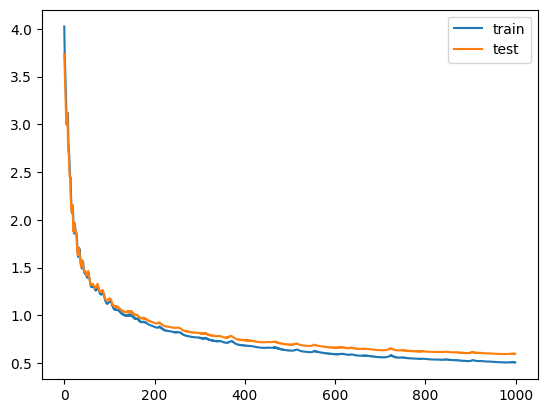

In [20]:
plt.plot(loss_list_train,label='train')
plt.plot(loss_list_test,label='test')

plt.legend()
plt.show()

## Train and Test Accuracy

In [21]:
# train accuracy
y_epred=torch.argmax(Y_ehat,dim=1,keepdim=True)
train_acc=torch.sum(Y_etrain==y_epred)/Y_etrain.shape[0]


# test accuracy
Z1_etest=X_etest@W1+b1
A1=torch.relu(Z1_etest)
Z2_etest=A1@W2 + b2

Y_hat_etest=softmax(Z2_etest)
y_pred_etest=torch.argmax(Y_hat_etest,dim=1,keepdim=True)
test_acc=torch.sum(Y_etest==y_pred_etest)/Y_etest.shape[0]

print(f"Train Accuracy: {train_acc}\
      \nTest Accuracy: {test_acc}")

Train Accuracy: 0.8376684188842773      
Test Accuracy: 0.8145212531089783


## Lets see what we got wrong prediction on

623


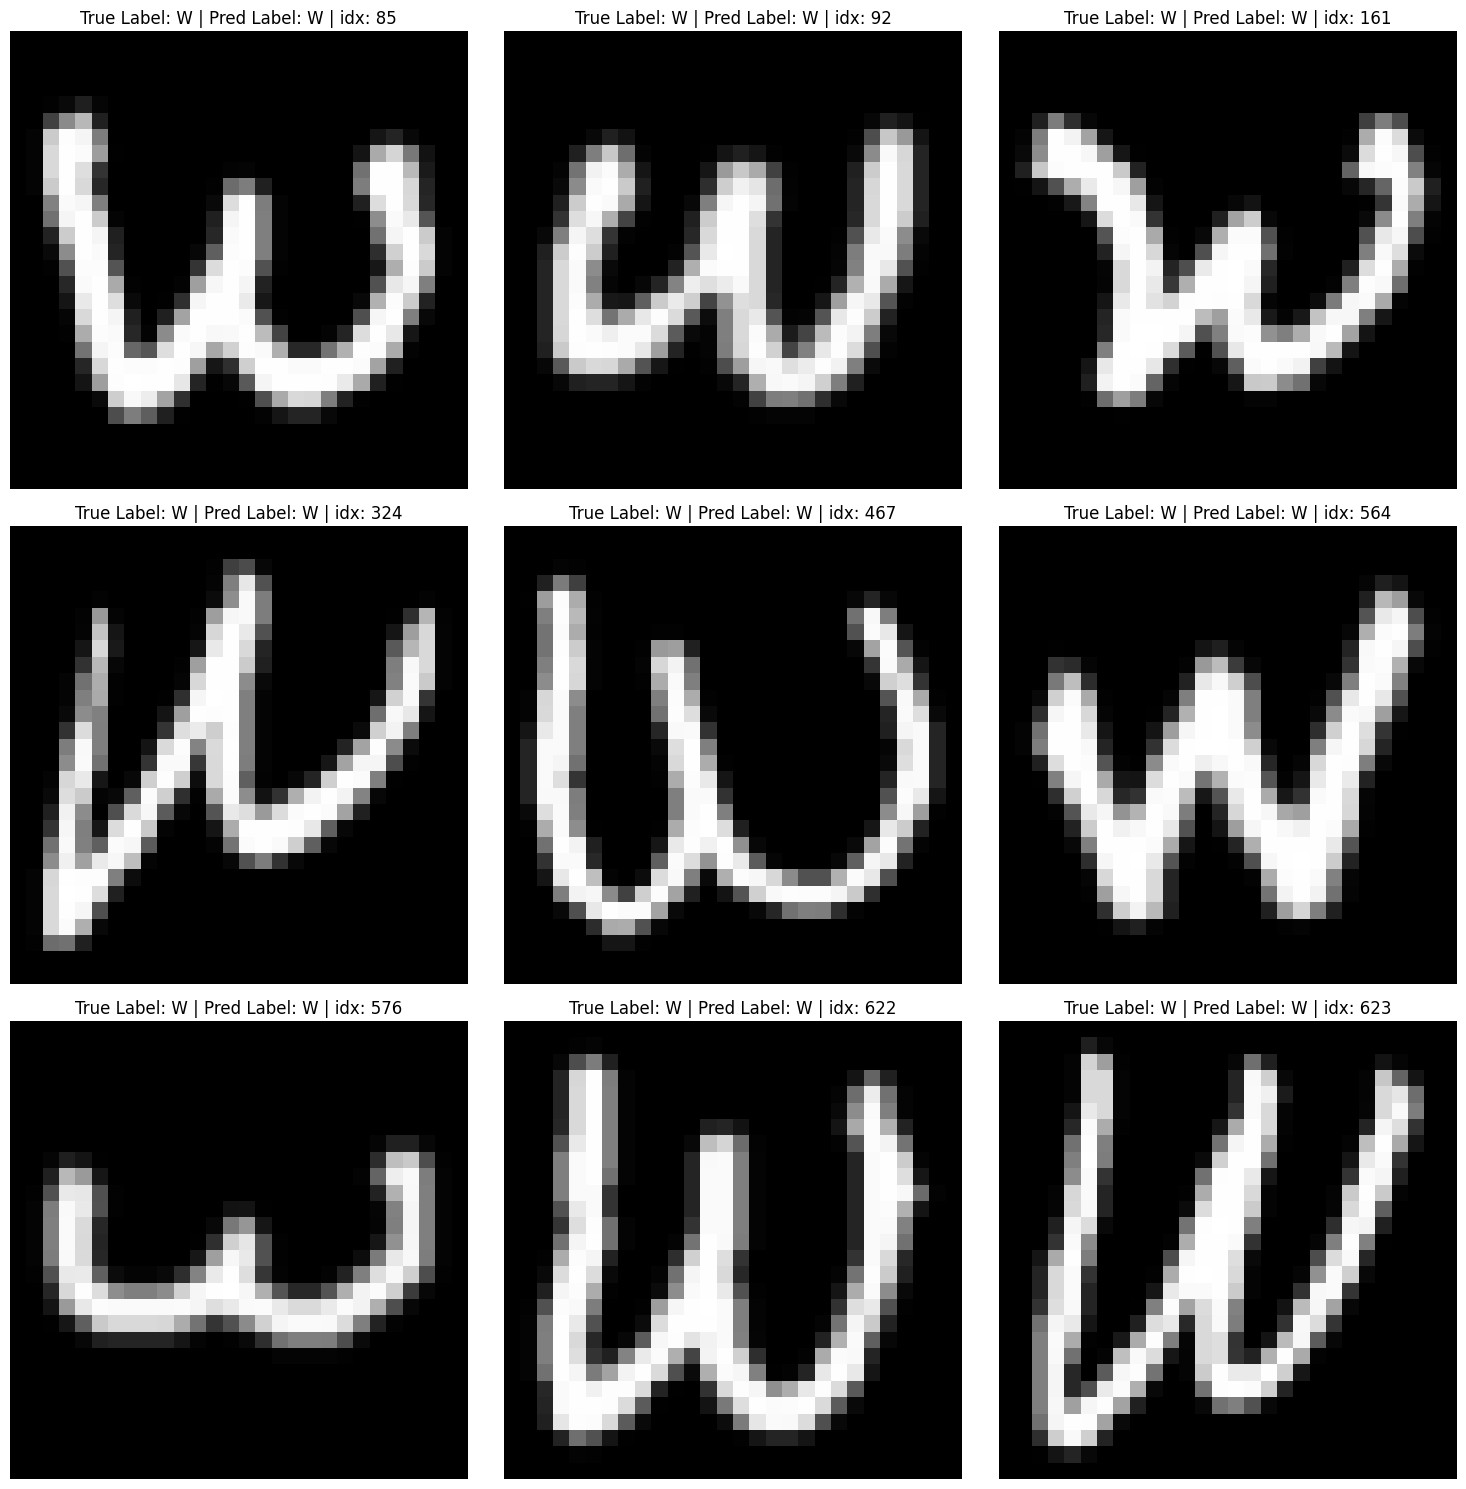

In [25]:
# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Plot images
# Plot images
c=-1
j=0
i=-1

end_loop=False

while i!=3:
    if end_loop:
        print(c)
        break
    i+=1
    j=0
    while j!=3:
        c+=1
        img, label = test_edata[c]  # Accessing each image and label
        if (list((train_edata.class_to_idx).keys())[label]=='W') and (label==y_pred_etest[c].item()):
            axs[i, j].imshow(img.squeeze().T,cmap='gray')
            axs[i, j].set_title(f'True Label: {list((train_edata.class_to_idx).keys())[label]} | Pred Label: {list((train_edata.class_to_idx).keys())[y_pred_etest[c].item()]} | idx: {c}')
            axs[i, j].axis('off')  # Hide axis
            j+=1
        if((c==40000) or (i==2 and j>2)):  # could scan maximum of 2k images and minimum of 81 elements
            end_loop=True
            break        


plt.tight_layout()
plt.show()

## Inferencing on Custom Image

torch.Size([1, 784])


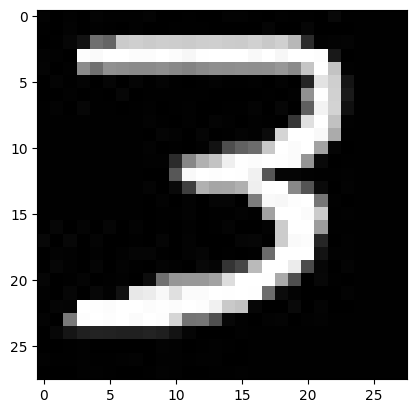

In [31]:
inf_img=torch.tensor(plt.imread('image4.jpeg'))

inf_img=inf_img[:,:,0].T

# flatten the image
inf_img=inf_img.flatten(0,1).reshape(1,-1)
print(inf_img.shape)
# scaling the image
inf_img=(inf_img-inf_img.min())/(inf_img.max()-inf_img.min())
plt.imshow(inf_img.view(28,28),cmap='gray')

In [32]:
# Prediction
Z1_inf=inf_img@W1+b1
A1=torch.relu(Z1_inf)
Z2_inf=A1@W2 + b2

Y_hat_inf=softmax(Z2_inf)
y_pred_inf=torch.argmax(Y_hat_inf,dim=1,keepdim=True)

print(f"The predicted character is: {list((train_edata.class_to_idx).keys())[y_pred_inf.item()]}")

The predicted character is: W


## Making Batch

In [10]:
#utitlity function to check manually calculated gradients with that of pytorch autograd
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [11]:

batch_size=32

# a single batch
X_btrain=X_etrain[:batch_size,:]
Y_btrain=Y_enc_etrain[:batch_size,:]

gamma=torch.randn((1,num_hidden),requires_grad=True)
beta=torch.randn((1,num_hidden),requires_grad=True)

X_btrain.shape,Y_btrain.shape



(torch.Size([32, 784]), torch.Size([32, 47]))

In [20]:
# forward pass
Z1=X_btrain@W1 + b1
A1=torch.relu(Z1)

A1_mean=A1.sum(dim=0,keepdim=True)/A1.shape[0]
A1_std=torch.sqrt(torch.sum(((A1-A1_mean)**2),dim=0)/A1.shape[0])
A1_norm=(A1-A1_mean)/(A1_std+1e-10)       # adding small term with std at the denominator to eliminate dividing by 0

A2=A1_norm*gamma+beta

Z2=A2@W2 + b2
Y_ehat=softmax(Z2)

Loss=categorical_cross_entropy(Y_btrain,Y_ehat)
# Loss=torch.sum((-Y_enc_etrain*torch.log(Y_ehat)),dim=1,keepdim=True).mean()

loss_list_train.append(Loss.item())

# # backpropgation
dL_dZ2=(Y_ehat-Y_btrain)/X_btrain.shape[0]
dZ2_dW2=A2

dL_dW2=dZ2_dW2.T@dL_dZ2
dL_db2=torch.sum(dL_dZ2,dim=0,keepdim=True)


dZ2_dA2=W2
dL_dA2= dL_dZ2 @ dZ2_dA2.T

dA2_dgamma=A1_norm
dL_dgamma=torch.sum(dL_dA2*dA2_dgamma,dim=0,keepdim=True)
dL_dbeta=torch.sum(dL_dA2,dim=0,keepdim=True)

dA2_dA1_norm=gamma  #---> shape (1,128)
dL_dA1_norm=dL_dA2*dA2_dA1_norm    # ----> (32,128)
dA1_norm_dA1_std= -(A1-A1_mean)*(A1_std**-2)
dL_dA1_std=dL_dA1_norm*dA1_norm_dA1_std             



# dA1_dZ1=torch.where((Z1<0),0, 1)

# dL_dZ1=(dA1_dZ1 * dL_dA1)

# dZ1_dW1=X_etrain

# dL_dW1=dZ1_dW1.T @ dL_dZ1
# dL_db1=torch.sum(dL_dZ1,dim=0,keepdim=True)

# # weights and biases optimization
# W2-=0.9*dL_dW2
# b2-=0.9*dL_db2
# W1-=0.9*dL_dW1
# b1-=0.9*dL_db1


## Retaining Gradient

In [21]:
for each in [Z2,A2,A1_norm,gamma,beta,A1_std,A1_mean,W1,W2,b1,b2,A1,Z1]:
    each.retain_grad()

In [14]:

Loss.backward()
# gamma.grad


In [22]:
cmp("dZ2", dL_dZ2, Z2)
cmp("dW2", dL_dW2, W2)
cmp("db2", dL_db2, b2)
cmp("dA2", dL_dA2, A2)
cmp("dgamma", dL_dgamma, gamma)
cmp("dbeta", dL_dbeta, beta)
cmp("dA1_norm", dL_dA1_norm, A1_norm)
cmp("dA1_std", dL_dA1_std, A1_std)


TypeError: all() received an invalid combination of arguments - got (bool), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, tuple of ints dim, bool keepdim, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, Tensor out)
 * (Tensor input, name dim, bool keepdim, *, Tensor out)
